In [10]:
# IMPORT ALL THE LIBRARIES USED IN THE NOTEBOOK
import math
import plotly.subplots as psu
import matplotlib.pyplot as plt
from waffles.data_classes.WaveformSet import WaveformSet
from waffles.data_classes.Waveform import Waveform
import numpy as np
from waffles.input.pickle_file_to_WaveformSet import pickle_file_to_WaveformSet
from glob import glob

In [11]:
import re
ch = 11225
filesresponse = sorted(glob(f'/eos/home-h/hvieirad/waffles/analysis/templates/*_ch{ch}.pkl'))
p = re.compile("run0(.....)_ch(.....).pkl")
wfsets = {}
for f in filesresponse:
    m = p.search(f)
    run = int(m.group(1))
    wfset = pickle_file_to_WaveformSet(f)
    wfsets[run] = wfset


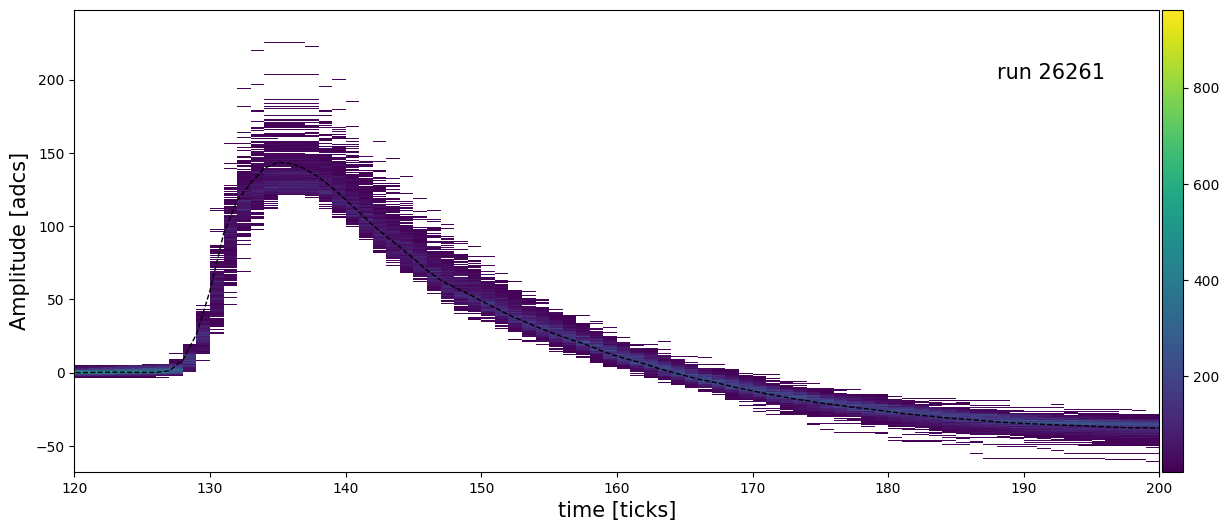

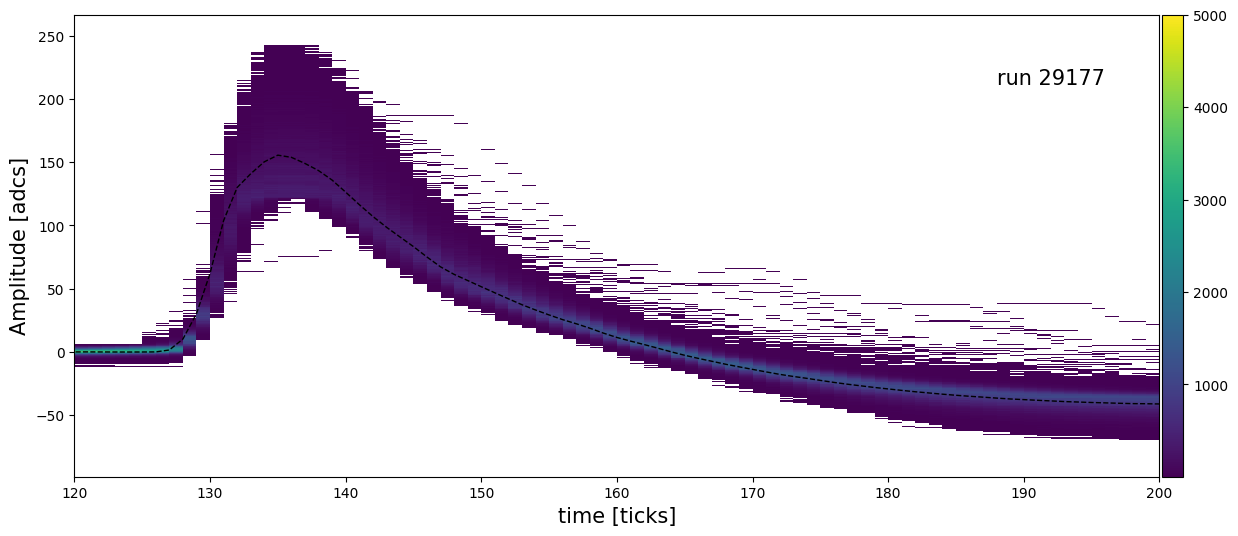

In [12]:
import ctypes
tv1filter = ctypes.cdll.LoadLibrary("/eos/home-h/hvieirad/waffles/waffles/src/waffles/data_classes/tv1ddenoise.o")
tv1filter.TV1D_denoise.argtypes = [ np.ctypeslib.ndpointer(dtype=np.float32), np.ctypeslib.ndpointer(dtype=np.float32), ctypes.c_int , ctypes.c_double ]
def persistence_plot(wfset_ch:WaveformSet, runnumber:int):

    filtered_wvfs = [ np.zeros_like(wvf.adcs, dtype=np.float32) for wvf in wfset_ch.waveforms ]
    npoints = len(wfset_ch.waveforms[0].adcs)
    for response, wvf in zip(filtered_wvfs, wfset_ch.waveforms):
        tv1filter.TV1D_denoise(wvf.adcs.astype(np.float32), response, npoints, 10)
    times = np.linspace(0, len(wfset_ch.waveforms[0].adcs),len(wfset_ch.waveforms[0].adcs))
    time_arrays = np.tile(times, (len(wfset_ch.waveforms), 1))
    wvf_arrays = np.array([(wvf - waveform.baseline)*-1 for wvf, waveform in zip(filtered_wvfs, wfset_ch.waveforms)])
    maxofall = np.max(wvf_arrays)*1.1
    minofall = np.min(wvf_arrays)*1.1

    h, yedges, xedges = np.histogram2d(wvf_arrays.flatten(), time_arrays.flatten(), bins=(500,1024), range = [[minofall,maxofall],[0,1024]])
    h[h==0] = np.nan
    fig, ax = plt.subplots(1, 1, figsize=(14,6))

    x, y = np.meshgrid(xedges, yedges)
    pcm = ax.pcolormesh(x, y, h)
    ax.set_ylabel("Amplitude [adcs]", fontsize=15)
    ax.set_xlabel("time [ticks]", fontsize=15)
    cax = ax.inset_axes([1.002, 0., 0.02, 1.])
    plt.colorbar(pcm, ax=ax, cax=cax)
    plt.text(0.85,0.85,f'run {runnumber}', transform=ax.transAxes, fontsize=15)

    avgwvf = wfset_ch.avgwvf
    plt.plot(avgwvf, '--k', lw=1)
    plt.xlim(120,200)


# for r, wf in list(wfsets.items())[-4:]:
#     persistence_plot(wf,r)
persistence_plot(wfsets[26261], 26261)
persistence_plot(wfsets[29177], 29177)


Text(0.5, 0, 'Time [ticks]')

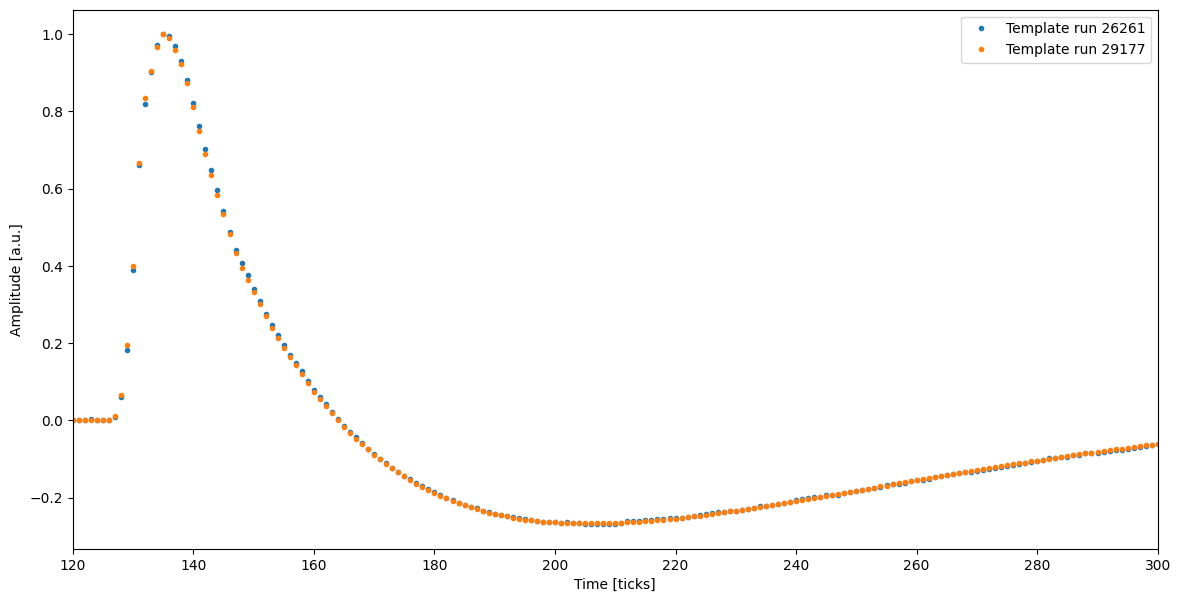

In [15]:
plt.figure(figsize=(14,7))
# for r, wf in wfsets.items():
#     plt.plot(wf.avgwvf/np.max(wf.avgwvf), label=r)
plt.plot(wfsets[26261].avgwvf/np.max(wfsets[26261].avgwvf), '.',label='Template run 26261')
plt.plot(wfsets[29177].avgwvf/np.max(wfsets[29177].avgwvf), '.',label='Template run 29177')
plt.legend()
    
plt.xlim(120,300)
plt.ylabel('Amplitude [a.u.]')
plt.xlabel('Time [ticks]')